A slightly class-ier version.  Hopefully this'll be the last 'generation' of notebook for this.  Anyone who's good at Python code reviews please follow along and give feedback :)

The plan is to document things *a lot* better as I go along and put things in a nice OO (and closer to PEP8) style.

The current biggest challenge is getting enough time to do this right :P

In [1]:
from base64 import b64encode
import copy
from datetime import datetime
import getopt
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls

Helper/graphing functions.  This will be broken out into it's own .py file once done.

In [2]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def todb(y, zero = False):
    db = 20 * np.log10(np.abs(y))
    if zero:
        return db - np.max(db)
    else:
        return db

def plotfilter_wh(w, h, freq, zero_base = False):
    db = todb(h, zero_base)
    
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilter(B, A, freq = 40, whole = False, zero_base = False):
    w, h = sps.freqz(B, A, whole = whole, worN=4096)
    
    if whole:
        w = np.arange(0, freq, freq / len(h))
    else:
        w = np.arange(0, (freq / 2), (freq / 2) / len(h))
        
    return plotfilter_wh(w, h, freq, zero_base)

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


For this part of the loader phase I found myself going to function objects that implement this sample API:

```
infile: standard readable/seekable python binary file
sample: starting sample #
readlen: # of samples
```
Returns data if successful, or None or an upstream exception if not (including if not enough data is available)

This might probably need to become a full object once FLAC support is added.

In [3]:

def load_unpacked_data(infile, sample, readlen):
    # this is run for unpacked data - 1 is for old cxadc data, 2 for 16bit DD
    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(readlen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata

def load_unpacked_data_u8(infile, sample, readlen):
    return load_unpacked_data(infile, sample, readlen, 1)

def load_unpacked_data_s16(infile, sample, readlen):
    return load_unpacked_data(infile, sample, readlen, 2)

# This is for the .r30 format I did in ddpack/unpack.c.  Depricated but I still have samples in it.
def load_packed_data_3_30(infile, sample, readlen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]


# The 10-bit samples from the Duplicator...

'''
From Simon's code:

// Original
// 0: xxxx xx00 0000 0000
// 1: xxxx xx11 1111 1111
// 2: xxxx xx22 2222 2222
// 3: xxxx xx33 3333 3333
//
// Packed:
// 0: 0000 0000 0011 1111
// 2: 1111 2222 2222 2233
// 4: 3333 3333
'''

# The bit twiddling is a bit more complex than I'd like... but eh.  I think
# it's debugged now. ;)
def load_packed_data_4_40(infile, sample, readlen):
    start = (sample // 4) * 5
    offset = sample % 4

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 5 // 4)) + 5

    inbuf = infile.read(needed)
    indata = np.frombuffer(inbuf, 'uint8', len(inbuf))

    rot2 = np.right_shift(indata, 2)

    unpacked = np.zeros(readlen + 4, dtype=np.uint16)

    # we need to load the 8-bit data into the 16-bit unpacked for left_shift to work
    # correctly...
    unpacked[0::4] = indata[0::5]
    np.left_shift(unpacked[0::4], 2, out=unpacked[0::4])
    np.bitwise_or(unpacked[0::4], np.bitwise_and(np.right_shift(indata[1::5], 6), 0x03), out=unpacked[0::4])

    unpacked[1::4] = np.bitwise_and(indata[1::5], 0x3f)
    np.left_shift(unpacked[1::4], 4, out=unpacked[1::4])
    np.bitwise_or(unpacked[1::4], np.bitwise_and(np.right_shift(indata[2::5], 4), 0x0f), out=unpacked[1::4])

    unpacked[2::4] = np.bitwise_and(indata[2::5], 0x0f)
    np.left_shift(unpacked[2::4], 6, out=unpacked[2::4])
    np.bitwise_or(unpacked[2::4], np.bitwise_and(np.right_shift(indata[3::5], 2), 0x3f), out=unpacked[2::4])

    unpacked[3::4] = np.bitwise_and(indata[3::5], 0x03)
    np.left_shift(unpacked[3::4], 8, out=unpacked[3::4])
    np.bitwise_or(unpacked[3::4], indata[4::5], out=unpacked[3::4])

    return unpacked[offset:offset + readlen]



In [4]:
# Essential standalone routines 

pi = np.pi
tau = np.pi * 2

#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter delays.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
#fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blocklen):
    return sps.freqz(filt[0], filt[1], blocklen, whole=1)[1]

In [5]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [6]:
def unwrap_hilbert(hilbert, freq_hz):
    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    return (tdangles2 * (freq_hz / tau))

In [7]:
# These are invariant parameters 
SysParams_NTSC = {
    'fsc_mhz': (315.0 / 88.0),
    'pilot_mhz': (315.0 / 88.0),
    'frame_lines': 525,

    'ire0': 8100000,
    'hz_ire': 1700000 / 140.0,

    # most NTSC disks have analog audio, except CD-V and a few Panasonic demos
    'analog_audio': True,
    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000*315/88/227.5) * 146.25,
    'audio_rfreq': (1000000*315/88/227.5) * 178.75,
}

# In color NTSC, the line period was changed from 63.5 to 227.5 color cycles,
# which works out to 63.5(with a bar on top) usec
SysParams_NTSC['line_period'] = 1/(SysParams_NTSC['fsc_mhz']/227.5)


In [8]:
class RFDecode:
    def __init__(self, freq = 40, system = 'NTSC', blocklen_ = 16384):
        self.blocklen = blocklen_
        self.blockcut = 512 # ???
        self.system = system
        
        self.freq = freq
        self.freq_half = freq / 2
        self.freq_hz = self.freq * 1000000
        self.freq_hz_half = self.freq * 1000000 / 2
        
        if system == 'NTSC':
            self.SysParams = SysParams_NTSC
                
            self.DecoderParams = {
                # The audio notch filters are important with DD v3.0+ boards
                'audio_notchwidth': 350000,
                'audio_notchorder': 2,

                # (note:  i don't know how to handle these values perfectly yet!)
                'video_deemp': (120*.32, 320*.32), # On some captures this is as low as .55.

                # This BPF similar but not *quite* identical to what Pioneer did
                'video_bpf': [3500000, 13200000],
                'video_bpf_order': 3,

                # This can easily be pushed up to 4.5mhz or even a bit higher. 
                # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
                'video_lpf_freq': 4200000,   # in mhz
                'video_lpf_order': 5 # butterworth filter order
            }
            
            self.Filters = {
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
            }

            
        self.computefilters()
            
    def computefilters(self):
        self.Filters = {}
        
        # Use some shorthand to compact the code.  good idea?  prolly not.
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams
        
        SF['hilbert'] = np.fft.fft(hilbert_filter, self.blocklen)
        
        filt_rfvideo = sps.butter(DP['video_bpf_order'], [DP['video_bpf'][0]/self.freq_hz_half, DP['video_bpf'][1]/self.freq_hz_half], btype='bandpass')
        SF['RFVideo'] = filtfft(filt_rfvideo, self.blocklen)

        if SP['analog_audio']: 
            cut_left = sps.butter(DP['audio_notchorder'], [(SP['audio_lfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_lfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutl'] = filtfft(cut_left, self.blocklen)
            cut_right = sps.butter(DP['audio_notchorder'], [(SP['audio_rfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_rfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutr'] = filtfft(cut_right, self.blocklen)
        
            SF['RFVideo'] *= (SF['Fcutl'] * SF['Fcutr'])
            
        SF['RFVideo'] *= SF['hilbert']
        
        video_lpf = sps.butter(DP['video_lpf_order'], DP['video_lpf_freq']/self.freq_hz_half, 'low')
        SF['Fvideo_lpf'] = filtfft(video_lpf, self.blocklen)

        # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
        deemp0, deemp1 = DP['video_deemp']
        [tf_b, tf_a] = sps.zpk2tf(-deemp1*(10**-10), -deemp0*(10**-10), deemp0 / deemp1)
        SF['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)

        # The direct opposite of the above, used in test signal generation
        [tf_b, tf_a] = sps.zpk2tf(-deemp0*(10**-10), -deemp1*(10**-10), deemp1 / deemp0)
        SF['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)
        
        # Post processing:  lowpass filter + deemp
        SF['FVideo'] = SF['Fvideo_lpf'] * SF['Fdeemp'] 
    
        # additional filters:  0.5mhz and color burst
        SF['F0_5'] = filtfft(sps.butter(4, 0.5/self.freq_half, 'low'), self.blocklen) 
        SF['FVideo05'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['F0_5']

        if self.system == 'NTSC':
            SF['Fburst_len'] = int(np.ceil((18 * self.freq_half / SP['fsc_mhz']) / 2) * 2)
            SF['Fburst_delay'] = SF['Fburst_len'] // 2
            bf = sps.firwin(SF['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/self.freq_half, (SP['fsc_mhz'] * 1.025)/self.freq_half], pass_zero=False)
            SF['Fburst'] = filtfft((bf, [1.0]), self.blocklen)
            SF['imglen'] = (int)((self.freq_hz / 59.976) * 1.25)
        else:
            # For PAL this is a 3.75mhz filter
            SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
            SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
        SF['FVideoBurst'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fburst']
        
        # emperical work determined that a single-pole low frequency filter effectively 
        # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
        f = sps.butter(1, 0.05/self.freq_half, btype='low')
        SF['FPsync'] = filtfft(f, self.blocklen)
        
    def iretohz(self, ire):
        return self.SysParams['ire0'] + (self.SysParams['hz_ire'] * ire)

    def hztoire(self, hz):
        return (hz - self.SysParams['ire0']) / self.SysParams['hz_ire']
    
    def demodblock(self, data, mtf_level = 0):
        indata_fft = np.fft.fft(data[:self.blocklen])
        indata_fft_filt = indata_fft * self.Filters['RFVideo']

        if mtf_level != 0:
            indata_fft_filt *= self.Filters['MTF'] ** mtf_level

        hilbert = np.fft.ifft(indata_fft_filt)
        demod = unwrap_hilbert(hilbert, self.freq_hz)

        demod_fft = np.fft.fft(demod)

        out_video = np.fft.ifft(demod_fft * self.Filters['FVideo']).real
        out_video05 = np.fft.ifft(demod_fft * self.Filters['FVideo05']).real
        out_videoburst = np.fft.ifft(demod_fft * self.Filters['FVideoBurst']).real
        
        if self.system == 'PAL':
            out_videopilot = np.fft.ifft(demod_fft * self.Filters['FVideoPilot']).real

        # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
        output_sync = inrange(out_video05, self.iretohz(-55), self.iretohz(-25))
        # Perform FFT convolution of above filter
        output_syncf = np.fft.ifft(np.fft.fft(output_sync) * self.Filters['FPsync']).real
        
        if self.system == 'PAL':
            out_videopilot = np.fft.ifft(demod_fft * paramsc['FVideoPilot']).real

            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst, out_videopilot], names=['demod', 'demod_05', 'demod_sync', 'demod_burst', 'demod_pilot'])
        else:
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

        if True or params['analog_audio'] == False:
            return rv_video, None

        # Audio section
        hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_lfilt'])
        audio_left = unwrap_hilbert(hilbert, paramsc['freq_arf']) + paramsc['audio_lowfreq']

        hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_rfilt'])
        audio_right = unwrap_hilbert(hilbert, paramsc['freq_arf']) + paramsc['audio_lowfreq']

        rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])

        return rv_video, rv_audio

    def demod(self, infile, start, end):
        end = int(end) + 1

        if (start > self.blockcut):
            start = int(start - self.blockcut)
        else:
            start = 0 # should this be an error?  prolly.

        # set a placeholder
        output = None
        output_audio = None

        for i in range(start, end, self.blocklen - self.blockcut):
            indata = loader(infile, i, self.blocklen)
            if indata is None:
                break

            tmp_video, tmp_audio = self.demodblock(indata)

            # if the output hasn't been created yet, do it now using the 
            # data types returned by dodemod (should be faster than multiple
            # allocations...)
            if output is None:
                output = np.zeros(end - start + 1, dtype=tmp_video.dtype)

            if i - start + (self.blocklen - self.blockcut) > len(output):
                copylen = len(output) - (i - start)
            else:
                copylen = self.blocklen - self.blockcut

            output_slice = slice(i - start, i - start + copylen)
            tmp_slice = slice(self.blockcut, self.blockcut + copylen)

            output[output_slice] = tmp_video[tmp_slice]

            # repeat the above - but for audio
            if tmp_audio is not None:
                audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]

                if output_audio is None:
                    output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)

                output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
                tmp_slice = slice(self.blockcut // audio_downscale, (self.blockcut + copylen) // audio_downscale)

                output_audio[output_slice] = tmp_audio[tmp_slice]

        return output, output_audio


In [13]:
SysParams = copy.deepcopy(SysParams_NTSC)

In [14]:
infile = open('/home/cpage/Downloads/dl-snippet-10bit.lds', 'rb')
loader = load_packed_data_4_40
data = loader(infile, 50000, 16384)

In [22]:
rfd = RFDecode()
rfd.computefilters()
#decode1 = foo.demodblock(data)

In [23]:
decode1 = rfd.demod(infile, 50000, 2500000)

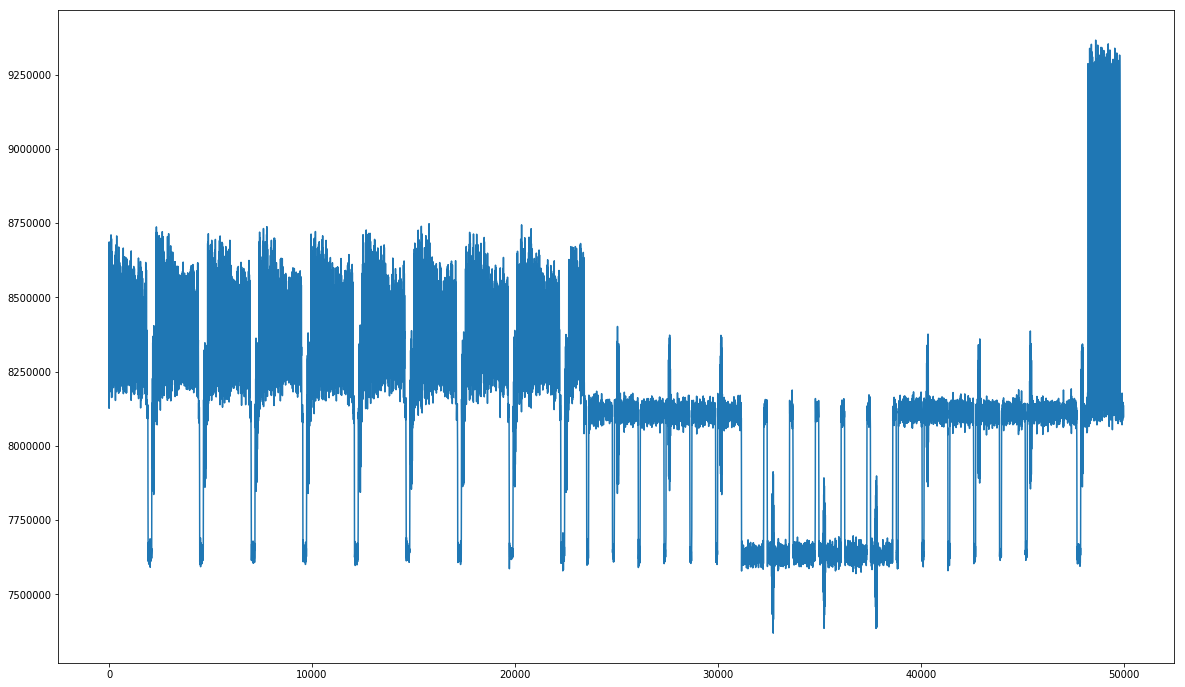

In [20]:
plt.plot(decode1[0]['demod'][0:50000])

(1588750,)
uint8 (625, 2542) (625, 2542)


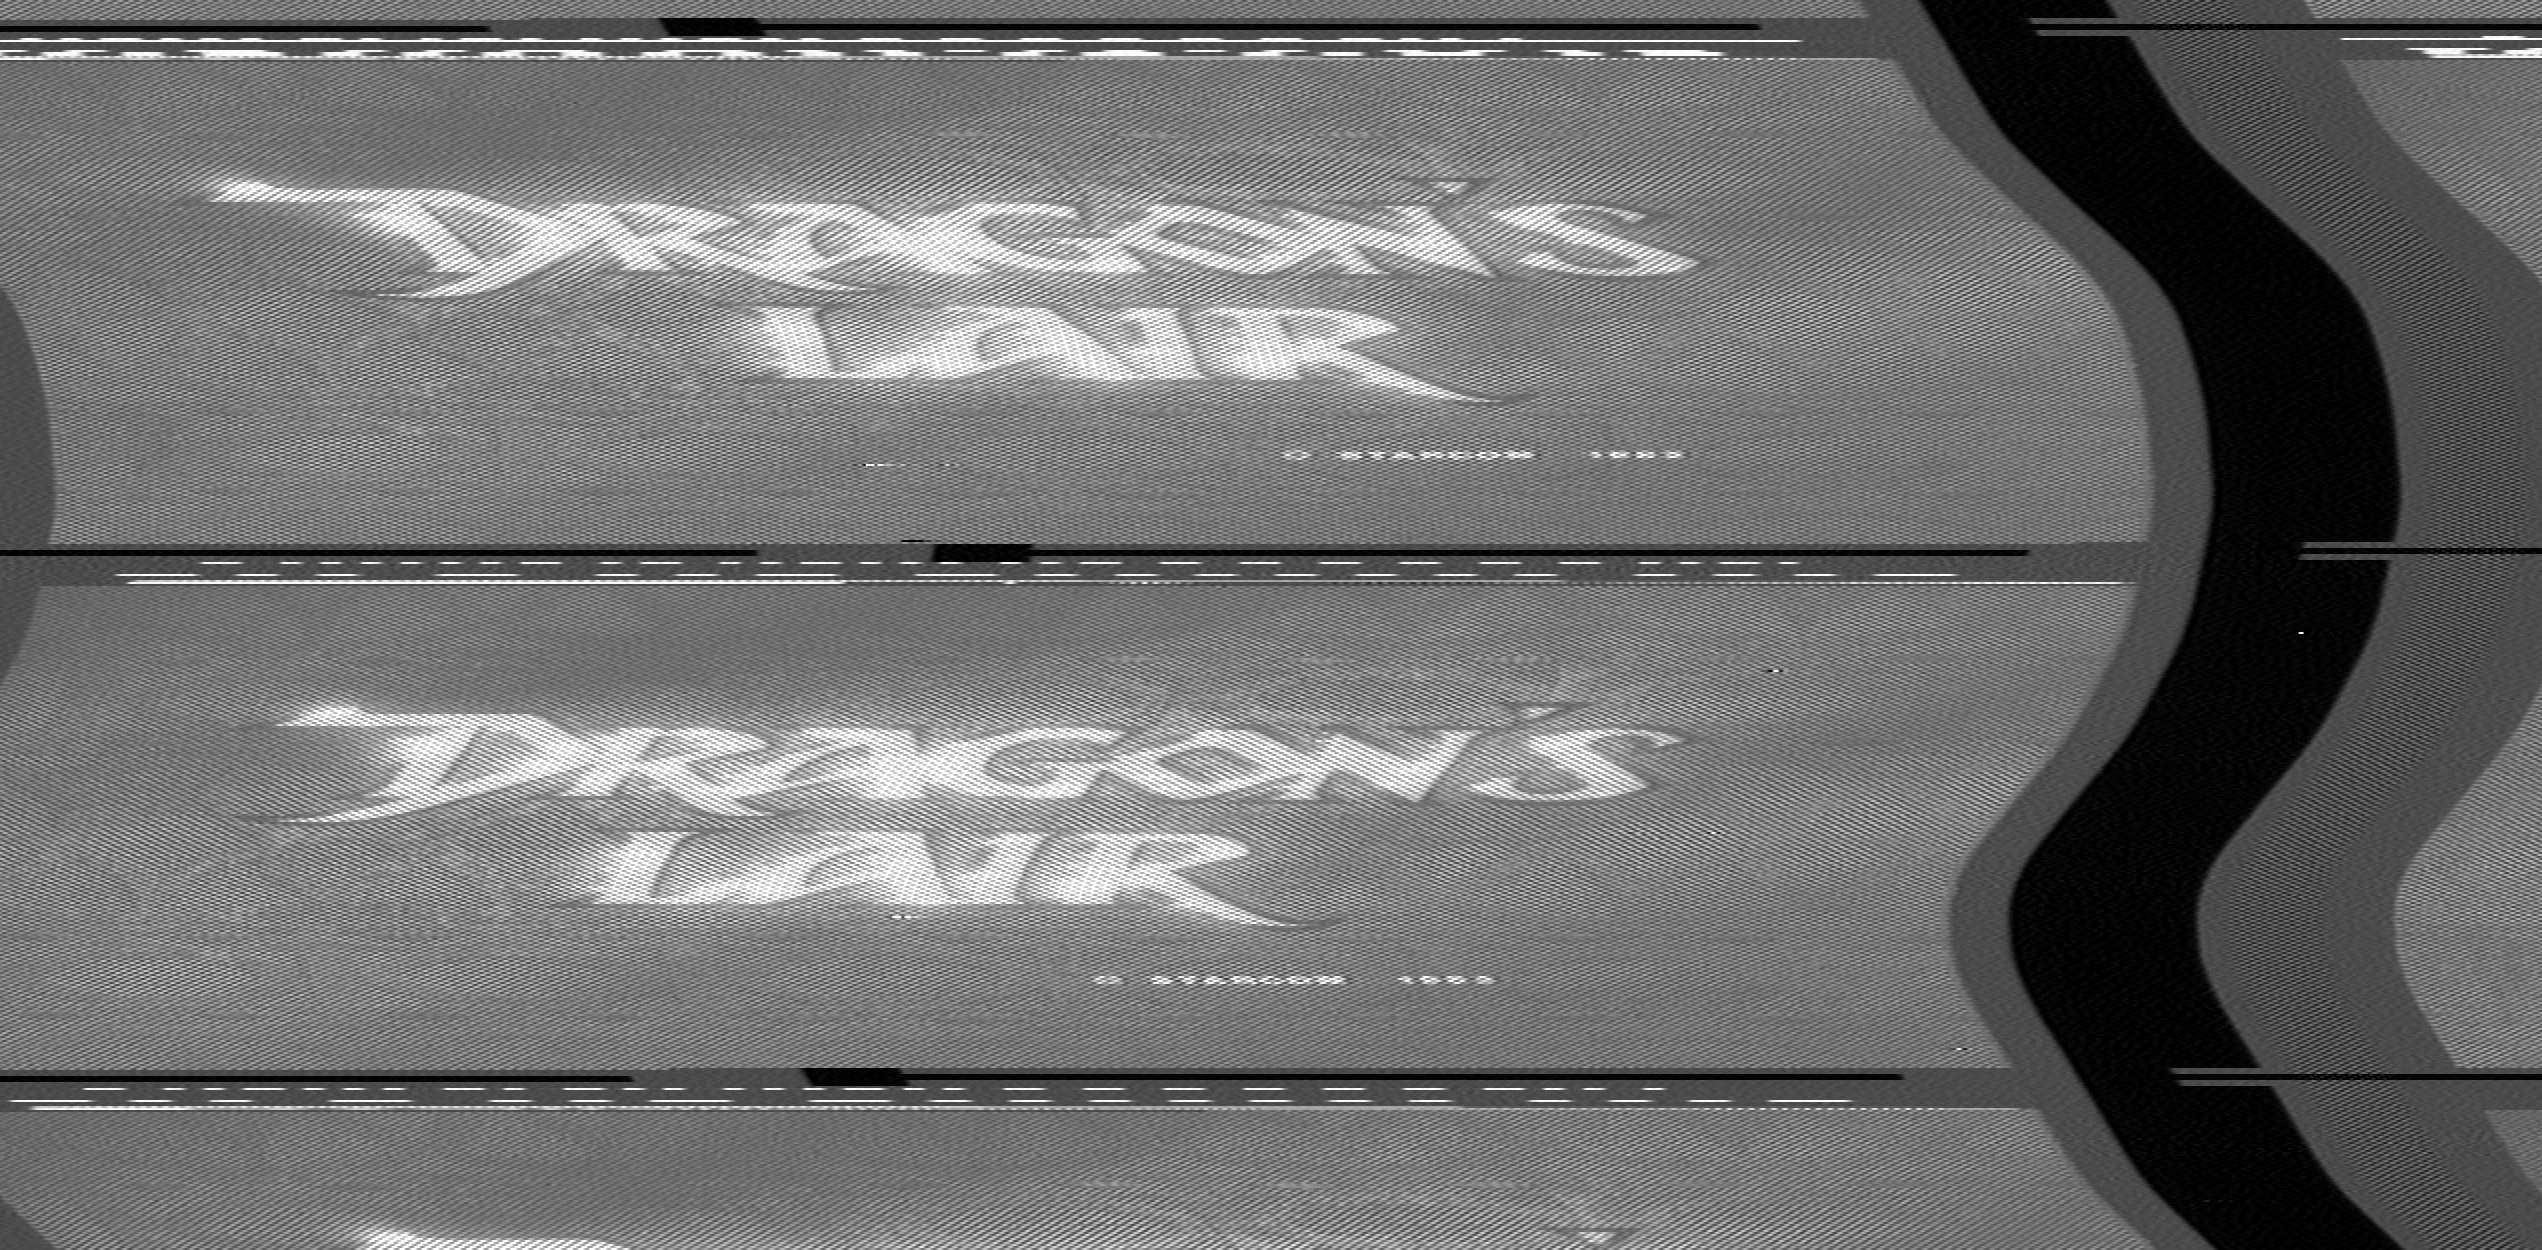

In [33]:
reduced = (decode1[0]['demod'][:2560*1250] - rfd.iretohz(-40)) / SysParams['hz_ire']
lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)
draw_raw_bwimage(lines16, 2542, 625, hscale=1, vscale=2)

In [40]:
linelen = 40000000/(1000000/SysParams['line_period'])
linelen = int(np.round(linelen))
linelen

2542

In [47]:
def calczc(data, _start_offset, target, edge='both', reverse=False, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    
    if edge == 'both': # capture rising or falling edge
        if data[start_offset] < target:
            edge = 'rising'
        else:
            edge = 'falling'

    if edge == 'rising':
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
               
    if len(locs) == 0:
        return None

    if reverse:
        index = -1
    else:
        index = 0
        
    x = start_offset + locs[index] #+ offset
    
    if (x == 0):
        print("BUG:  cannot figure out zero crossing for beginning of data")
        return None
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [48]:
# run 12 peaks after first vsync to determine if this line's a keeper
def calc_vsync_linegaps(peaklist, baseline):
    for i in range(baseline, baseline - 7, -1):
        if peaklist[i][1] > .7 and peaklist[i + 1][1] < .6:
            tgap = peaklist[i + 1][0] - peaklist[i][0]

    for j in range(baseline + 3, baseline + 12, 1):
        if peaklist[j][1] > .7 and peaklist[j - 1][1] < .6:
            tgap += peaklist[j][0] - peaklist[j - 1][0]

    return i, tgap < (linelen * 1.5)

In [52]:

def haveframe(peaklist, vsyncs):
    if len(vsyncs) < 3:
        return False
    
    return (len(peaklist) - vsyncs[2]) > 16

def findsync_getpulses(frame, start):
    """returns: line #'s (zero delimited/padded, starts with 1) and gap to next frame """
    ds = frame['demod_sync']
    
    peaklist = []
    vsyncs = []
    
    linezero = None
    tgtire = -21.5
    
    # This is done as a while loop so each peak lookup is aligned to the previous one
    i = start
    while i < (len(ds) - linelen) and not haveframe(peaklist, vsyncs):
        #print(i)
        peakloc = np.argmax(ds[i:i + (linelen//2)]) #+ start
        peak = ds[i + peakloc]

        if peak > .3:
            # TODO: validity check for lack of rot goes here?

            if (len(peaklist) > 15) and (peaklist[-1][1] < .6) and (peak > .99):
                vsyncs.append(len(peaklist) - 1)
                
            # TODO: work out magic # for 48
            lineloc = i + peakloc + 48
            zc = calczc(frame['demod'][lineloc:], 0, rfd.iretohz(tgtire), _count=16)
            if zc is not None:
                lineloc += zc            

            peaklist.append((lineloc, peak))

            # This allows all peaks to get caught properly
            i += peakloc + int(linelen * .4)
        else:
            i += linelen // 2

        if len(vsyncs) and (len(peaklist) - vsyncs[0]) == 12:
            linezero, is_beginning = calc_vsync_linegaps(peaklist, vsyncs[0])

            if not is_beginning: 
                return None, np.int(peaklist[linezero][0] + (linelen * 300))

    if not haveframe(peaklist, vsyncs):
        print(peaklist[vsyncs[0]][0] - (8 * linelen))

    # now build the line location list
    linelocs = [peaklist[linezero][0]]
    
    for i in range(linezero + 1, vsyncs[2] + 8):
        if inrange(peaklist[i][1], 0.7, 0.85): # full line
            linelocs.append(peaklist[i][0])
        elif inrange(peaklist[i][1], 0.4, 0.55):
            if inrange(peaklist[i][0] - linelocs[-1], linelen * .95, linelen * 1.05):
                # XXX: magic # offset
                linelocs.append(peaklist[i][0] + 45)
        elif (peaklist[i][1] > .95) and (peaklist[i-1][1] < .95): # add three lines 
            gap = linelocs[-1] - linelocs[-2]
            linelocs.append(linelocs[-1] + gap)
            linelocs.append(linelocs[-1] + gap)
            linelocs.append(linelocs[-1] + gap)
        else:
            # skip for now
            None
            
    # XXX: magic #
    linelocs = np.array(linelocs) # - filterset['dgap_sync'] + 48
            
    return linelocs, linelocs[-4]

pulses = (None, 0)
while pulses[0] is None:
    pulses = findsync_getpulses(decode1[0], pulses[1])

In [64]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    
def downscale_field(data, lineinfo, wow = None, outwidth=1820, lines=625):
    ilinepx = linelen
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 525):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        if wow is not None:
            scaled /= wow[l]
        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor


In [66]:
outlinelen = (4 * 1000000 * 315 / 88) / (1000000/SysParams['line_period'])
outlinelen = int(np.round(outlinelen))

910

In [67]:
rv = downscale_field(decode1[0]['demod'], pulses[0], outwidth=outlinelen)

(477750,)
uint8 (525, 910) (525, 910)


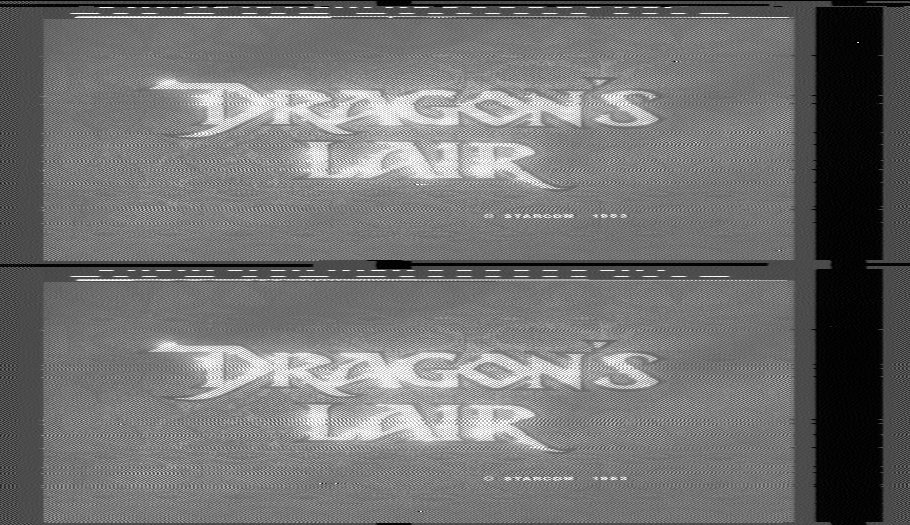

In [69]:
reduced = (rv[0] - rfd.iretohz(-40)) / SysParams['hz_ire']
lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)

draw_raw_bwimage(lines16, outlinelen, 525, hscale=1, vscale=1)

In [17]:
class Framer:
    def __init__(self):
        returna
    
    

In [128]:
foo.filters

{'Fcutl': array([1.        +0.j        , 0.99999989-0.00047224j,
        0.99999955-0.00094447j, ..., 0.999999  +0.00141672j,
        0.99999955+0.00094447j, 0.99999989+0.00047224j]),
 'Fcutr': array([1.        +0.j        , 0.99999995-0.00031536j,
        0.9999998 -0.00063073j, ..., 0.99999955+0.0009461j ,
        0.9999998 +0.00063073j, 0.99999995+0.00031536j]),
 'RFVideo': array([-7.20862603e-17+0.00000000e+00j, -3.49404459e-13-1.81789157e-10j,
        -5.58622377e-12-1.45430639e-09j, ...,
        -2.82802819e-11+4.90824537e-09j, -5.58622377e-12+1.45430639e-09j,
        -3.49404459e-13+1.81789157e-10j]),
 'hilbert': array([ 8.32667268e-17+0.j        ,  1.09651923e-02-0.00053869j,
         2.22482790e-02-0.00219126j, ..., -3.01577675e-02-0.00447348j,
        -2.06379261e-02-0.00203266j, -1.05609962e-02-0.00051883j])}